In [91]:
import time
import numpy as np
from numpy.fft import rfftn, irfftn
import matplotlib.pyplot as plt
from ipywidgets import interact
import pickthat
%matplotlib inline

In [3]:
api = pickthat.API()
u = api.users()
list(filter(lambda i: '__' not in i, dir(u[3])))

['biography',
 'education',
 'email',
 'environment',
 'experience',
 'linkedin',
 'location',
 'nickname',
 'profession',
 'user_id']

In [4]:
api = pickthat.API()
p = api.images()
p[1].link

'http://lh3.googleusercontent.com/1bg394j9LNZIZ_oRv6FAyooH4dKwY1ke_mcxfc-Bdr1Q7GBGlc0ED1DqZDN5cOIEBbIpBTCxYTMRycWPgaLtDA'

In [5]:
[q.title for q in p]

['Brain MRI',
 'Bouguer gravity map, Southern Tuscany, Italy',
 'Namibian margin',
 'Mancora seismic',
 'Baby tooth in full grown adult',
 'Cell counting',
 'Sobrarbe',
 '2D marine data  from  Southern shelf of Marmara sea ( ın front of the Imralı Basin) ',
 'Ho ho ho',
 'Alaska seismic',
 "Where's the salt?",
 'Ireland seismic',
 'Brazil seismic',
 'Photomicrograph',
 'Parametric Echosounder Profile ',
 'Nova Scotia seismic',
 'Salter–Harris',
 'Synthetic seismic over a thrust',
 'Seismic Oceanography',
 'Marmousi Synthetic',
 '',
 'Mediterranean Sea Evaporites 2D Seismic',
 'Browse basin',
 'Deuteranope ROYGBIV',
 'Parasound profile']

In [6]:
img = [q for q in p if q.title == "Brazil seismic"][0]

In [7]:
# import requests
# from PIL import Image
# from io import BytesIO
# r = requests.get(i[2].link)
# im = Image.open(BytesIO(r.content))

In [34]:
png = img.image()
size = np.shape(img.image())
aspect = png.width / png.height

In [35]:
picks = api.picks(image_id = img.image_id)
picks[:10]

In [36]:
list(filter(lambda i: '__' not in i, picks[0].__dir__()))

['ip_addr', 'picks', 'user_id', 'date', 'cohort']

In [38]:
len(picks)  # Should be ~430 for Brazil.

430

## Use Shapely and Rasterio to generate heatmap

In [39]:
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry.linestring import LineString
from shapely.geometry.multilinestring import MultiLineString
from rasterio import features

In [132]:
def apply_buffer(row, buffer=1):
    r = np.array(row)
    these_lines = []
    if r.shape[-1] == 2:
        cohort = np.ones((r.shape[0]))
        groups = cohort
    if r.shape[-1] == 3:
        groups = r[:,2]
    for group in np.unique(groups):
        this_line = r[groups==group][:, :2]
        if len(this_line) > 1:
            #these_lines.append(LineString(this_line).buffer(buffer))
            these_lines.append(LineString(this_line))
        else:  # single point, discard
            continue
    #return MultiPolygon(these_lines)
    return MultiLineString(these_lines)

In [133]:
def buffered_heatmap(image_size, picks, weights=None, buffer=5):
    """
    returns a heatmap the same size as the test image
    """
    weights = weights or np.ones((len(picks)))

    shapes = []
    for p, w in zip(picks, weights):
        if len(p.picks) != 0:
            shape = apply_buffer(p.picks, buffer)
            shapes.append((shape, w))  
    heatmap = np.zeros(image_size)
    for i, _ in enumerate(shapes):
        heatmap += features.rasterize(shapes[i:i+1],
                                      out_shape=heatmap.shape,
                                      all_touched=True)
    return heatmap

In [134]:
%timeit shapely_heatmap(np.shape(img.image())[:2], picks, buffer=1)

ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped


1 loops, best of 3: 1.34 s per loop


In [141]:
def _check_valid_mode_shapes(shape1, shape2):
    for d1, d2 in zip(shape1, shape2):
        if not d1 >= d2:
            raise ValueError(
                "in1 should have at least as many items as in2 in "
                "every dimension for 'valid' mode.")

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

def _next_regular(target):
    """
    Find the next regular number greater than or equal to target.
    Regular numbers are composites of the prime factors 2, 3, and 5.
    Also known as 5-smooth numbers or Hamming numbers, these are the optimal
    size for inputs to FFTPACK.
    Target must be a positive integer.
    """
    if target <= 6:
        return target

    # Quickly check if it's already a power of 2
    if not (target & (target-1)):
        return target

    match = float('inf')  # Anything found will be smaller
    p5 = 1
    while p5 < target:
        p35 = p5
        while p35 < target:
            # Ceiling integer division, avoiding conversion to float
            # (quotient = ceil(target / p35))
            quotient = -(-target // p35)

            # Quickly find next power of 2 >= quotient
            try:
                p2 = 2**((quotient - 1).bit_length())
            except AttributeError:
                # Fallback for Python <2.7
                p2 = 2**(len(bin(quotient - 1)) - 2)

            N = p2 * p35
            if N == target:
                return N
            elif N < match:
                match = N
            p35 *= 3
            if p35 == target:
                return p35
        if p35 < match:
            match = p35
        p5 *= 5
        if p5 == target:
            return p5
    if p5 < match:
        match = p5
    return match

def my_fft_convolve(in1, in2, mode='full'):
    """
    Returns the output of the heatmap convolved with a smoothing kernel. 
    The only dependency used is NumPy
    heatmap : 2-dimensional NumPy array size: (m, n)
    kernel : 2-d NumPy array size: (p, q)
    """
    in1 = np.asarray(in1)
    in2 = np.asarray(in2)

    if in1.ndim == in2.ndim == 0:  # scalar inputs
        return in1 * in2
    elif not in1.ndim == in2.ndim:
        raise ValueError("in1 and in2 should have the same dimensionality")
    elif in1.size == 0 or in2.size == 0:  # empty arrays
        return array([])

    s1 = np.array(in1.shape)
    s2 = np.array(in2.shape)
    complex_result = (np.issubdtype(in1.dtype, np.complex) or
                      np.issubdtype(in2.dtype, np.complex))
    shape = s1 + s2 - 1

    if mode == "valid":
        _check_valid_mode_shapes(s1, s2)

    # Speed up FFT by padding to optimal size for FFTPACK
    fshape = [_next_regular(int(d)) for d in shape]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    # Pre-1.9 NumPy FFT routines are not threadsafe.  For older NumPys, make
    # sure we only call rfftn/irfftn from one thread at a time.
    if not complex_result:
        ret = irfftn(rfftn(in1, fshape) *
                         rfftn(in2, fshape), fshape)[fslice].copy()
    else:
        # If we're here, it's either because we need a complex result, or we
        # failed to acquire _rfft_lock (meaning rfftn isn't threadsafe and
        # is already in use by another thread).  In either case, use the
        # (threadsafe but slower) SciPy complex-FFT routines instead.
        ret = ifftn(fftn(in1, fshape) * fftn(in2, fshape))[fslice].copy()
        if not complex_result:
            ret = ret.real

    if mode == "full":
        return ret
    elif mode == "same":
        return _centered(ret, s1)
    elif mode == "valid":
        return _centered(ret, s1 - s2 + 1)
    else:
        raise ValueError("Acceptable mode flags are 'valid',"
                         " 'same', or 'full'.")

def kernel(i,j):
    return np.ones((i,j))/(i*j)

## Heatmap generation using NumPy simple 2-D convolutional smoothing

/Users/Evan/anaconda/envs/pickthat/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped


Time taken to make heatmap: 3.94 seconds.


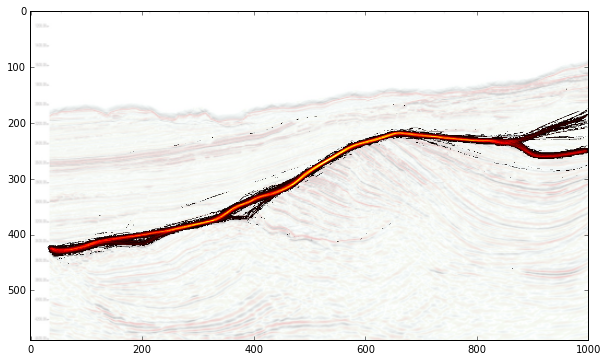

In [140]:
heat = shapely_heatmap((dx/aspect,dx), picks, buffer=0.1)
@interact(i=(1,20), j=(1,20), threshold=(0,10))
def make_heatmap(i=1,j=1,threshold=1):
    start = time.time()
    out = my_fft_convolve(heat, kernel(i,j), mode='same')
    out[out <= threshold] = np.nan
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.imshow(img.image(), alpha=0.2, extent=[0,1000,1000/aspect,0])
    ax.imshow(out, cmap='hot')
    end = time.time()
    elapsed = end - start
    print("Time taken to make heatmap: {:.2f} seconds.".format(elapsed))

## Heatmap generation by buffering MultiLineStrings into MultiPolygons using Shapely

/Users/Evan/anaconda/envs/pickthat/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'type': 'MultiLineString', 'coordinates': ()} at index 0 with value 1 skipped


Time taken to make heatmap: 4.25 seconds.


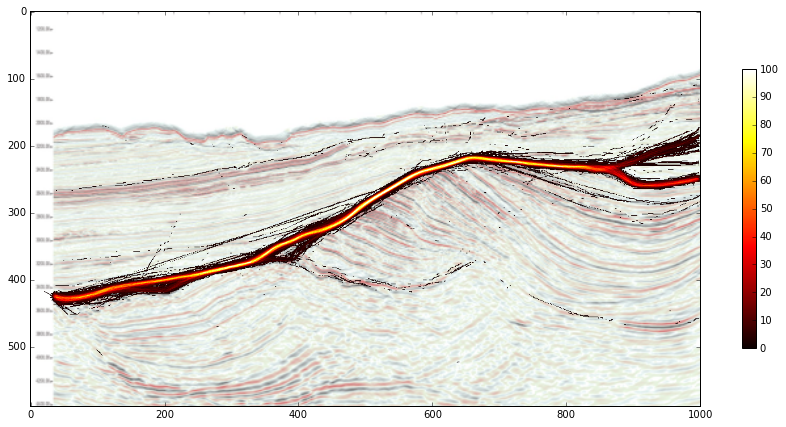

In [26]:
@interact(i=(1,7), j=(0.0,1.0), k=(0.0,1.0))
def draw_heatmap(i=3,j=1.0, k=0.5):
    start = time.time()
    heatmap = shapely_heatmap((dx*aspect,dx), picks, buffer=0.1)
    heatmap[heatmap <= 1] = np.nan
    plt.figure(figsize=(15,10))
    plt.imshow(img.image(), alpha=k, extent=[0,dx,aspect*dx,0])
    plt.imshow(heatmap, cmap='hot', clim=([0,100]), alpha=j)
    plt.colorbar(shrink=0.5)
    end = time.time()
    elapsed = end - start
    print("Time taken to make heatmap: {:.2f} seconds.".format(elapsed))


## Getting the image

In [145]:
p.loc[images['image_id']==image_id]

AttributeError: 'list' object has no attribute 'loc'

In [ ]:
link = images.loc[images['image_id']==image_id].link[2]
IPImage(url=link)

## Put it all together

In [ ]:
import urllib
from PIL import Image

In [ ]:
# Get the image
link = images.loc[images['image_id']==image_id].link[2]
f = urllib.request.urlopen(link)
img = Image.open(f)

plt.figure(figsize=(12,8))
plt.imshow(img)

for line in these_lines:
    x, y = line.xy
    plt.plot(x, y, color='k', lw=3, alpha=0.75)

plt.show()

In [ ]:
x, y = mls[0].xy
plt.plot(x, y)

In [ ]:
h = images.loc[images['image_id']==image_id].height[2]
w = images.loc[images['image_id']==image_id].width[2]
h, w

## Users

In [ ]:
u = api.users()
u[2].__dict__

## Picks

In [ ]:
image_id = 5910974510923776
api.picks()

In [ ]:
picks.head()